/var/folders/wr/z8_6_fcj1jn4k8nbbpb4m8x40000gn/T/ipykernel_94803/523607025.py:35: RuntimeWarning: invalid value encountered in scalar divide
  d = (a * point[0] + b * point[1] + c) / (a**2 + b**2)


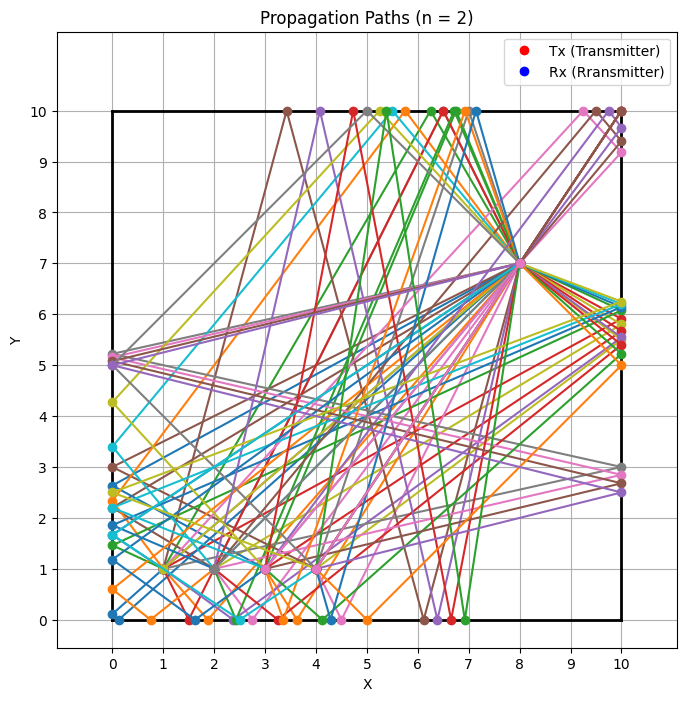

In [6]:
import itertools
import numpy as np
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

# 壁の設定 (始点と終点)
walls = np.array([
    [[0,0],[0,10]],
    [[10,0],[0,0]],
    [[0,10], [10,10]],
    [[10,10],[10,0]],
])

obstacles = np.array([
    [[0,11],[0,11]],
])

# 送信機と受信機の座標
ants = np.array([[1, 1],[2, 1],[3,1],[4,1]])
tag = np.array([8, 7])

# 最大反射回数
max_reflections = 2

def l2_normalize(x):
    x_norm = np.linalg.norm(x,ord=2)
    return x / x_norm

def calculate_mirror_point(point, wall):
    x1, y1 = wall[0]
    x2, y2 = wall[1]
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    d = (a * point[0] + b * point[1] + c) / (a**2 + b**2)
    x_mirror = point[0] - 2 * a * d
    y_mirror = point[1] - 2 * b * d
    return (x_mirror, y_mirror)

def find_mirror_points(ant, walls):
    current_point = ant
    mirror_points = []

    # 鏡像点を順番に計算
    for wall in walls:
        current_point = calculate_mirror_point(current_point, wall)
        mirror_points.append(current_point)

    return mirror_points

def get_reflection_vector(start_point,end_point,wall):
    path = end_point - start_point
    wall_vector = wall[1]-wall[0]
    normal = np.array([wall_vector[1],-wall_vector[0]])
    path = l2_normalize(path)
    normal = l2_normalize(normal)
    reflection_vector = path + 2*(-np.dot(path,normal))*normal
    return reflection_vector

def get_reflection_points(ant,tag,mirror_points,walls,):
    walls = walls[::-1]
    mirror_points = mirror_points[::-1]
    n_reflections = len(mirror_points)
    reflection_points = []
    start_point = tag
    end_point = mirror_points[0]
    for i in range(n_reflections):
        wall_line = LineString(walls[i])
        path_line = LineString([start_point, end_point])
        if wall_line.intersects(path_line):
            ref_path = get_reflection_vector(start_point,end_point,walls[i])
            inter = wall_line.intersection(path_line)
            start_point = np.array([inter.x, inter.y])
            if i == n_reflections-1:
                end_point = ant
            else: end_point = mirror_points[i+1]
            path = end_point-start_point
            path_norm = l2_normalize(path)
            ref_path_norm = l2_normalize(ref_path)
            dot = np.dot(path_norm, ref_path_norm)
            if np.abs(dot - 1.0) < 1e-9 : 
                reflection_points.append(start_point)
            else:
                return []
        else: 
            return []
    reflection_points.append(ant)
    reflection_points.reverse()
    reflection_points.append(tag)
    return reflection_points

def find_reflection_points(ant,tag,walls,obstacles,n_reflections):
    all_reflection_points = []
    wall_combinations = list(itertools.product(np.concatenate([walls, obstacles], axis=0), repeat=n_reflections))  # 壁の組み合わせ
    for walls in wall_combinations:
        mirror_points = find_mirror_points(ant, walls)
        ref_points = get_reflection_points(ant,tag,mirror_points,walls)
        if len(ref_points) >= (n_reflections + 2):
            all_reflection_points.append(ref_points)
    return all_reflection_points

all_reflection_points = []
for n_reflections in range(1,max_reflections+1): 
    for ant in ants:
        reflection_points = find_reflection_points(ant,tag,walls,obstacles,n_reflections)
        all_reflection_points = all_reflection_points + reflection_points + [[ant,tag]]

def visualize_mirror_points(ant, tag, walls, reflection_points):
    plt.figure(figsize=(8, 8))
    plt.title(f"Propagation Paths (n = {max_reflections})")
    plt.xlabel("X")
    plt.ylabel("Y")

    # 壁を描画
    for wall in walls:
        wall_line = LineString(wall)
        x, y = wall_line.xy
        plt.plot(x, y, 'k-', linewidth=2, )

    # タグ、アンテナを描画
    plt.plot(ant[0], ant[1], 'ro', label="Tx (Transmitter)")
    plt.plot(tag[0], tag[1], 'bo', label="Rx (Rransmitter)")

    # 鏡像点を描画
    for i, reflection_points in enumerate(reflection_points):
        reflection_points = np.array(reflection_points).T
        plt.plot(reflection_points[0],reflection_points[1],linestyle='-', marker='o',)
        # for j, point in enumerate(reflection_points):
            # plt.plot(point[0], point[1],linestyle='--', marker='o',)
            # plt.text(point[0], point[1], f"({point[0]:.1f}, {point[1]:.1f})", fontsize=8, color="green")

    plt.xticks(range(0,11,1))
    plt.yticks(range(0,11,1))

    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

# 鏡像点を可視化
# for n_reflections in range(1,max_reflections+1):
visualize_mirror_points(ant, tag, np.concatenate([walls, obstacles], axis=0), all_reflection_points)
